# Import

In [107]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import datetime
import pickle
from matplotlib import pyplot as plt
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from sklearn.metrics import multilabel_confusion_matrix
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2021-01-02T18Z


# Use Colab ?

In [2]:
USE_COLAB = True # change to 0 if not use colab
RootFolder = ''
if (USE_COLAB):
    RootFolder = '/content/drive/MyDrive/MiAI_Hand_Lang/' # root folder tren drive
else:
    RootFolder = 'D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/___CuoiKi/Code/MiAI_Hand_Lang/' # root folder tren may

In [5]:
if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
if USE_COLAB:
    %cd $RootFolder
    %cd ..
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

/content/drive/MyDrive/MiAI_Hand_Lang
/content/drive/MyDrive
Done@2021-01-02T15Z


# Declare variable and function

In [7]:
# Dinh nghia cac bien

gestures = {'L_': 'L',
           'fi': 'E',
           'ok': 'F',
           'pe': 'V',
           'pa': 'B'
            }

gestures_map = {'E': 0,
                'L': 1,
                'F': 2,
                'V': 3,
                'B': 4
                }


gesture_names = {0: 'E',
                 1: 'L',
                 2: 'F',
                 3: 'V',
                 4: 'B'}


image_path = RootFolder + 'data/'
models_path = RootFolder + 'models/saved_model.hdf5'
rgb = False
imageSize = 224


# Ham xu ly anh resize ve 224x224 va chuyen ve numpy array
def process_image(path):
    img = Image.open(path)
    img = img.resize((imageSize, imageSize))
    img = np.array(img)
    return img

# Xu ly du lieu dau vao
def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

# Ham duyet thu muc anh dung de train
def walk_file_tree(image_path):
    X_data = []
    y_data = []
    for directory, subdirectories, files in os.walk(image_path):
        for file in files:
            if not file.startswith('.'):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                # print(gesture_name)
                # print(gestures_map[gesture_name])
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2021-01-02T15Z


In [14]:
# Load du lieu vao X va Y
print(image_path)
X_data, y_data = walk_file_tree(image_path)
print("X_data.shape = ", X_data.shape)
print("y_data.shape = ", y_data.shape)
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

/content/drive/MyDrive/MiAI_Hand_Lang/data/
X_data.shape =  (2748, 224, 224, 3)
y_data.shape =  (2748, 5)
Done@2021-01-02T16Z


# Initialize model

In [39]:
# Dat cac checkpoint de luu lai model tot nhat
model_checkpoint = ModelCheckpoint(filepath=models_path, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [40]:
# Khoi tao model
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()
base_model = model1

In [41]:
# Them cac lop ben tren
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc2a')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

In [42]:
# Them lop cuoi
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [43]:
# Dong bang cac lop duoi, chi train lop ben tren minh them vao
for layer in base_model.layers:
    layer.trainable = False

# Split whold data to Train, Test Set


*   Train Set: use K-Fold (K=5) in order to evaluation model, after evaluation, train model base whole Train Set
*   Test Set: use final model to test on this



In [20]:
# Phan chia du lieu train va test theo ty le 80/20
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

In [21]:
# split X_train to 5-Fold
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=12)
splits = list(kf.split(X_train))
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2021-01-02T16Z


# Train 6 model: 5 model to evaluation (use K-Fold), 1 model is final model (trained on whole train set)

## Train Fold 0 --> Fold 4, save history to file

In [71]:
for i in range(5):
  train_indices, val_indices = splits[i]
  X_train_k = X_train[train_indices]
  X_val_k = X_train[val_indices]
  y_train_k = y_train[train_indices]
  y_val_k = y_train[val_indices]
  # Train Fold
  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
  hist_k = model.fit(X_train_k, y_train_k, epochs=50, batch_size=64, validation_data=(X_val_k, y_val_k), verbose=1)
  # save history to file
  f_k = open(RootFolder + 'history/history_final' + str(i) + '.pckl', 'wb')
  pickle.dump(hist_k.history, f_k)
  f_k.close()
  print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Epoch 1/50
28/28 [==============================] - 12s 417ms/step - loss: 0.0565 - accuracy: 0.9813 - val_loss: 0.0317 - val_accuracy: 0.9886
Epoch 2/50
28/28 [==============================] - 8s 290ms/step - loss: 0.0189 - accuracy: 0.9930 - val_loss: 2.9690e-04 - val_accuracy: 1.0000
Epoch 3/50
28/28 [==============================] - 8s 294ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 3.9960e-04 - val_accuracy: 1.0000
Epoch 4/50
28/28 [==============================] - 8s 298ms/step - loss: 4.8359e-04 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9977
Epoch 5/50
28/28 [==============================] - 8s 302ms/step - loss: 5.9630e-04 - accuracy: 1.0000 - val_loss: 6.8982e-04 - val_accuracy: 1.0000
Epoch 6/50
28/28 [==============================] - 9s 306ms/step - loss: 0.0060 - accuracy: 0.9988 - val_loss: 0.0025 - val_accuracy: 0.9977
Epoch 7/50
28/28 [==============================] - 8s 303ms/step - loss: 0.0443 - accuracy: 0.9848 - val_loss: 0.0429 - val_ac

# Draw train loss, val loss

## K-Fold's

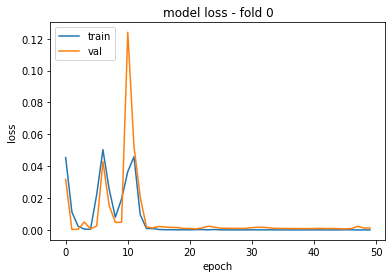

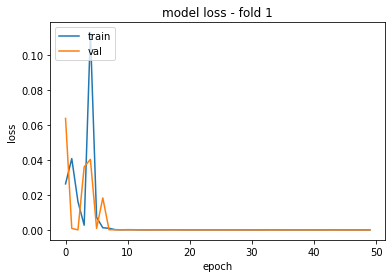

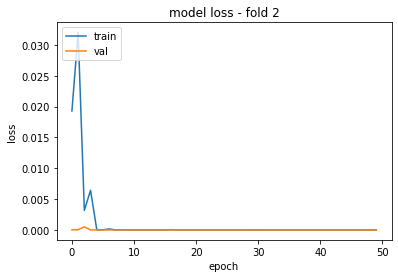

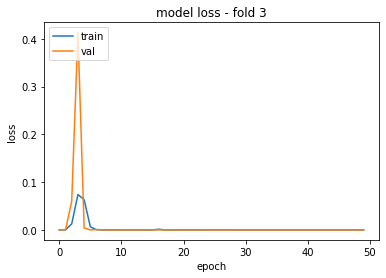

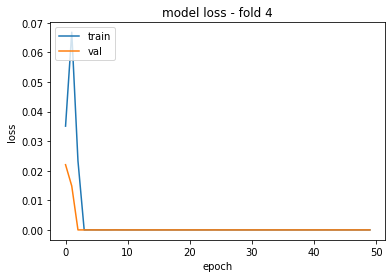

Done@2021-01-02T17Z


In [72]:
for i in range(5):
  # retrieve:    
  f_k = open(RootFolder + 'history/history_final' + str(i) + '.pckl', 'rb')
  history_k = pickle.load(f_k)
  f_k.close()
  # plot
  plt.plot(history_k['loss'])
  plt.plot(history_k['val_loss'])
  plt.title('model loss - fold ' + str(i))
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

In [73]:
f_0 = open(RootFolder + 'history/history_final0.pckl', 'rb')
history_0 = pickle.load(f_0)
f_0.close()
f_1 = open(RootFolder + 'history/history_final1.pckl', 'rb')
history_1 = pickle.load(f_1)
f_1.close()
f_2 = open(RootFolder + 'history/history_final2.pckl', 'rb')
history_2 = pickle.load(f_2)
f_2.close()
f_3 = open(RootFolder + 'history/history_final3.pckl', 'rb')
history_3 = pickle.load(f_3)
f_3.close()
f_4 = open(RootFolder + 'history/history_final4.pckl', 'rb')
history_4 = pickle.load(f_4)
f_4.close()

In [64]:
print(np.array(history_0['loss']).flatten().shape)

(24,)


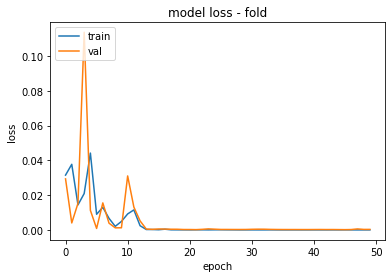

Done@2021-01-02T17Z


In [74]:
# plot loss line
plt.plot((np.array(history_0['loss']) + np.array(history_1['loss']) + \
          np.array(history_2['loss']) + np.array(history_3['loss']) + \
          np.array(history_4['loss'])) / 4)
plt.plot((np.array(history_0['val_loss']) + np.array(history_1['val_loss']) + \
          np.array(history_2['val_loss']) + np.array(history_3['val_loss']) + \
          np.array(history_4['val_loss'])) / 4)
plt.title('model loss - fold')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

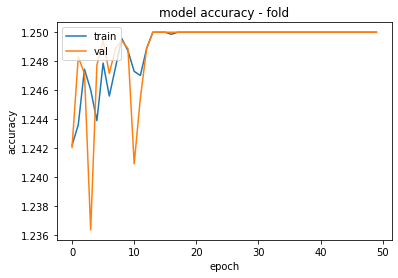

Done@2021-01-02T17Z


In [75]:
# plot accuracy line
plt.plot((np.array(history_0['accuracy']) + np.array(history_1['accuracy']) + np.array(history_2['accuracy']) + np.array(history_3['accuracy']) + np.array(history_4['accuracy'])) / 4)
plt.plot((np.array(history_0['val_accuracy']) + np.array(history_1['val_accuracy']) + np.array(history_2['val_accuracy']) + np.array(history_3['val_accuracy']) + np.array(history_4['val_accuracy'])) / 4)
plt.title('model accuracy - fold')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

## Final Model

In [80]:
# Final model
early_stopping = EarlyStopping(monitor='accuracy',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1) # epoch cho nay tu chon
# save history to file
f = open(RootFolder + 'history/history_final.pckl', 'wb')
pickle.dump(hist.history, f)
f.close()
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Epoch 1/30
35/35 [==============================] - 9s 228ms/step - loss: 0.0035 - accuracy: 0.9989
Epoch 2/30
35/35 [==============================] - 8s 231ms/step - loss: 0.0084 - accuracy: 0.9980
Epoch 3/30
35/35 [==============================] - 8s 236ms/step - loss: 0.0139 - accuracy: 0.9977
Epoch 4/30
35/35 [==============================] - 8s 239ms/step - loss: 0.0375 - accuracy: 0.9946
Epoch 5/30
35/35 [==============================] - 8s 240ms/step - loss: 0.0012 - accuracy: 0.9991
Epoch 6/30
35/35 [==============================] - 8s 240ms/step - loss: 4.6425e-05 - accuracy: 1.0000
Epoch 7/30
35/35 [==============================] - 8s 238ms/step - loss: 1.1111e-04 - accuracy: 1.0000
Epoch 8/30
35/35 [==============================] - 8s 235ms/step - loss: 1.0563e-05 - accuracy: 1.0000
Epoch 9/30
35/35 [==============================] - 8s 233ms/step - loss: 5.9517e-06 - accuracy: 1.0000
Epoch 10/30
35/35 [==============================] - 8s 232ms/step - loss: 9.6270e-0

## Final Model's

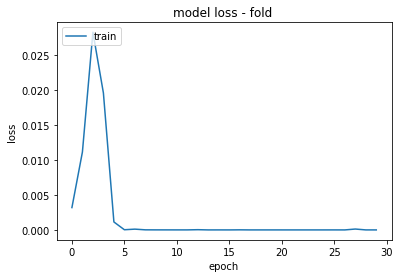

Done@2021-01-02T17Z


In [81]:
  f = open(RootFolder + 'history/history_final.pckl', 'rb')
  history = pickle.load(f)
  f.close()
  # plot
  plt.plot(history['loss'])
  # plt.plot(history['val_loss'])
  plt.title('model loss - fold ')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

## Save final model

In [82]:
# Luu model da train ra file
import datetime
model.save(RootFolder + 'models/mymodel_final.h5')
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2021-01-02T17Z


# Download file

In [ ]:
# download file tu colab ve
if (USE_COLAB):
    from google.colab import files
    files.download(RootFolder + 'models/mymodel_final.h5')
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

In [ ]:
if (USE_COLAB):
    from google.colab import files
    for i in range(5):
      files.download(RootFolder + 'history/history_final' + str(i) + '.pckl')  
    files.download(RootFolder + 'history/history_final.pckl')
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

# Confusion Matrix

In [83]:
model_trained = load_model(RootFolder + 'models/mymodel_final.h5')
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2021-01-02T17Z


In [84]:
y_pred = model_trained.predict(X_test)
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2021-01-02T17Z


## Label y_pred and y_test

In [85]:
# labled y_pred
print(y_pred.shape)
y_pred_labelled = []
for i in range(0, 550):
    y_pred_labelled.append(gesture_names[np.argmax(y_pred[i])])
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

(550, 5)
Done@2021-01-02T17Z


In [86]:
# labled y_test
print(y_test.shape)
y_test_labelled = []
for i in range(0, 550):
    y_test_labelled.append(gesture_names[np.argmax(y_test[i])])
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

(550, 5)
Done@2021-01-02T17Z


### Confusion Matrix for Multiple Classes


Act Label\Pred Label| E | L | F | V | B
---:|:---:|:---:|:---:| ---
**E** | Pee | Pel | Pef | Pev | Pev
**L** | Ple | Pll | Plf | Plv | Plv
**F** | Pfe | Pfl | Pff | Pfv | Pfv
**V** | Pve | Pvl | Pvf | Pvv | Pvv
**B** | Pbe | Pbl | Pbf | Pbv | Pbv

In [87]:
conf_mat = confusion_matrix(y_test_labelled, y_pred_labelled, labels=["E", "L", "F", "V", "B"])
table = tabulate(conf_mat, headers=["E", "L", "F", "V", "B"], tablefmt='fancy_grid')
print("Confusion Matrix")
print(table)
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Confusion Matrix
╒═════╤═════╤═════╤═════╤═════╕
│   E │   L │   F │   V │   B │
╞═════╪═════╪═════╪═════╪═════╡
│ 110 │   0 │   0 │   0 │   0 │
├─────┼─────┼─────┼─────┼─────┤
│   1 │ 108 │   0 │   1 │   0 │
├─────┼─────┼─────┼─────┼─────┤
│   0 │   0 │ 110 │   0 │   0 │
├─────┼─────┼─────┼─────┼─────┤
│   0 │   0 │   0 │ 108 │   2 │
├─────┼─────┼─────┼─────┼─────┤
│   1 │   0 │   0 │   0 │ 109 │
╘═════╧═════╧═════╧═════╧═════╛
Done@2021-01-02T17Z


### Confusion Matrix for each Label
Actual\Predict| Pred Neg | Pred Pos
---:|:---:| ---
**Act Neg** | TN | FP
**Act Pos** | FN | TP

In [88]:
mul_conf_mat = multilabel_confusion_matrix(y_test_labelled, y_pred_labelled, labels=["E", "L", "F", "V", "B"])
table = tabulate(mul_conf_mat[0], tablefmt='fancy_grid')
print("E")
print(table)
table = tabulate(mul_conf_mat[1], tablefmt='fancy_grid')
print("L")
print(table)
table = tabulate(mul_conf_mat[2], tablefmt='fancy_grid')
print("F")
print(table)
table = tabulate(mul_conf_mat[3], tablefmt='fancy_grid')
print("V")
print(table)
table = tabulate(mul_conf_mat[4], tablefmt='fancy_grid')
print("B")
print(table)
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

E
╒═════╤═════╕
│ 438 │   2 │
├─────┼─────┤
│   0 │ 110 │
╘═════╧═════╛
L
╒═════╤═════╕
│ 440 │   0 │
├─────┼─────┤
│   2 │ 108 │
╘═════╧═════╛
F
╒═════╤═════╕
│ 440 │   0 │
├─────┼─────┤
│   0 │ 110 │
╘═════╧═════╛
V
╒═════╤═════╕
│ 439 │   1 │
├─────┼─────┤
│   2 │ 108 │
╘═════╧═════╛
B
╒═════╤═════╕
│ 438 │   2 │
├─────┼─────┤
│   1 │ 109 │
╘═════╧═════╛
Done@2021-01-02T17Z


In [89]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_labelled, y_pred_labelled)

0.990909090909091

## Measure Accuracy base Confusion matrix

In [90]:
np.sum(conf_mat)
accur = (conf_mat[0,0] + conf_mat[1,1] + conf_mat[2,2] + conf_mat[3,3] + conf_mat[4,4]) / np.sum(conf_mat)
print(accur)

0.990909090909091


In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
tf.test.is_built_with_cuda()

True

In [12]:
print(tf.version.VERSION)

2.4.0


In [13]:
import sys
sys.version

'3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'